In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/liar_dataset

/content/drive/MyDrive/Colab Notebooks/liar_dataset


In [ ]:
# 1. Imports
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# 2. Load Data
col_names = [
    'id','label','statement','subjects','speaker','job_title','state','party',
    'count_barely_true','count_false','count_half_true','count_mostly_true','count_pants_on_fire',
    'context'
]
df = pd.read_csv('train.tsv', sep='\t', header=None, names=col_names)
df_val = pd.read_csv('valid.tsv', sep='\t', header=None, names=col_names)
df_test = pd.read_csv('test.tsv', sep='\t', header=None, names=col_names)

In [ ]:
# 3. Text Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r"[^a-z0-9\s]", ' ', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

for df_ in [df, df_val, df_test]:
    df_['statement'] = df_['statement'].astype(str).apply(clean_text)


In [ ]:
# 4. Label Encoding
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
df_val['label_enc'] = le.transform(df_val['label'])
df_test['label_enc'] = le.transform(df_test['label'])

In [ ]:
# 5. Prepare Data
X_train, y_train = df['statement'], df['label_enc']
X_val, y_val = df_val['statement'], df_val['label_enc']
X_test, y_test = df_test['statement'], df_test['label_enc']

In [ ]:
# 6. Tokenize & Pad
MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB)
tokenizer.fit_on_texts(X_train)

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN)
X_val_pad   = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=MAX_LEN)
X_test_pad  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN)

In [ ]:
# 7. Build Model
input_layer = Input(shape=(MAX_LEN,))
embed = Embedding(MAX_VOCAB, 100)(input_layer)
lstm = LSTM(64)(embed)
drop = Dropout(0.2)(lstm)
output = Dense(len(le.classes_), activation='softmax')(drop)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,042,630 (3.98 MB)

 Trainable params: 1,042,630 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 8. Train
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=32,
    verbose=2
)

Epoch 1/10
320/320 - 4s - 12ms/step - accuracy: 0.2234 - loss: 1.7449 - val_accuracy: 0.2492 - val_loss: 1.7114
Epoch 2/10
320/320 - 2s - 7ms/step - accuracy: 0.3384 - loss: 1.5977 - val_accuracy: 0.2391 - val_loss: 1.7566
Epoch 3/10
320/320 - 2s - 7ms/step - accuracy: 0.5055 - loss: 1.2911 - val_accuracy: 0.2344 - val_loss: 1.8843
Epoch 4/10
320/320 - 2s - 7ms/step - accuracy: 0.6519 - loss: 0.9448 - val_accuracy: 0.2165 - val_loss: 2.2301
Epoch 5/10
320/320 - 2s - 7ms/step - accuracy: 0.7549 - loss: 0.6894 - val_accuracy: 0.2220 - val_loss: 2.5940
Epoch 6/10
320/320 - 2s - 7ms/step - accuracy: 0.8247 - loss: 0.5063 - val_accuracy: 0.2188 - val_loss: 2.9610
Epoch 7/10
320/320 - 2s - 7ms/step - accuracy: 0.8776 - loss: 0.3672 - val_accuracy: 0.2259 - val_loss: 3.3025
Epoch 8/10
320/320 - 2s - 7ms/step - accuracy: 0.9042 - loss: 0.2841 - val_accuracy: 0.2321 - val_loss: 3.6865
Epoch 9/10
320/320 - 2s - 7ms/step - accuracy: 0.9225 - loss: 0.2288 - val_accuracy: 0.2344 - val_loss: 3.9489


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

 barely-true       0.23      0.23      0.23       237
       false       0.25      0.26      0.26       263
   half-true       0.19      0.18      0.18       248
 mostly-true       0.25      0.23      0.24       251
  pants-fire       0.24      0.16      0.19       116
        true       0.19      0.26      0.22       169

    accuracy                           0.22      1284
   macro avg       0.22      0.22      0.22      1284
weighted avg       0.23      0.22      0.22      1284

Macro F1: 0.21918839267717335
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

=== Test Set Evaluation ===
              precision    recall  f1-score   support

 barely-true       0.23      0.24      0.23       212
       false       0.30      0.30      0.30       249
   half-true       0.24      0.20      0.22       265
 mostly-true       0.22      0.25      0.23       241
  pants-fire       0.18      0.15      0.17      

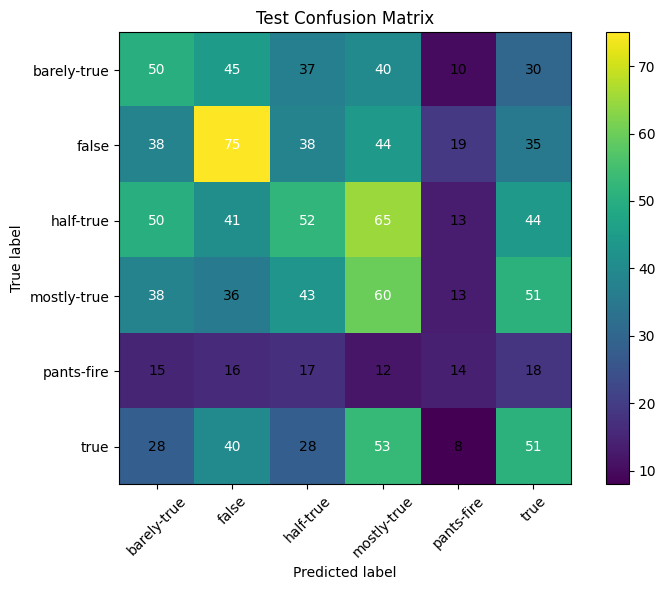

In [ ]:
# 11. Evaluate Validation Set
y_val_pred = np.argmax(model.predict(X_val_pad), axis=1)
print(classification_report(y_val, y_val_pred, target_names=le.classes_))
print('Macro F1:', f1_score(y_val, y_val_pred, average='macro'))

# 12. evaluate Test Set
if 'label' in df_test.columns and not df_test['label'].isnull().any():
    y_test = le.transform(df_test['label'].astype(str))
    y_test_pred_prob = model.predict(X_test_pad)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)

    print("\n=== Test Set Evaluation ===")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))
    print('Macro F1 (test):', f1_score(y_test, y_test_pred, average='macro'))

    try:
        test_roc_auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
        print('ROC AUC (test):', test_roc_auc)
    except:
        pass

    cm_test = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm_test, interpolation='nearest')
    plt.title('Test Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(le.classes_))
    plt.xticks(tick_marks, le.classes_, rotation=45)
    plt.yticks(tick_marks, le.classes_)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i in range(len(cm_test)):
        for j in range(len(cm_test)):
            plt.text(j, i, cm_test[i, j], ha='center', va='center',
                     color='white' if cm_test[i, j] > cm_test.max()/2 else 'black')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No label column in test.tsv, skipping test evaluation.")


In [ ]:
from sklearn.metrics import roc_auc_score

# calculate ROC AUC for test set
y_test_pred_proba = model.predict(X_test_pad)
try:
    test_roc_auc = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')
    print('ROC AUC (test):', test_roc_auc)
except Exception as e:
    print("ROC AUC (test) failed:", e)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
ROC AUC (test): 0.5630800715228793


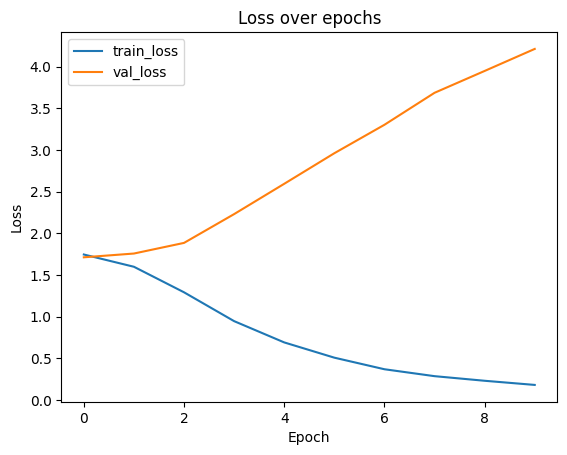

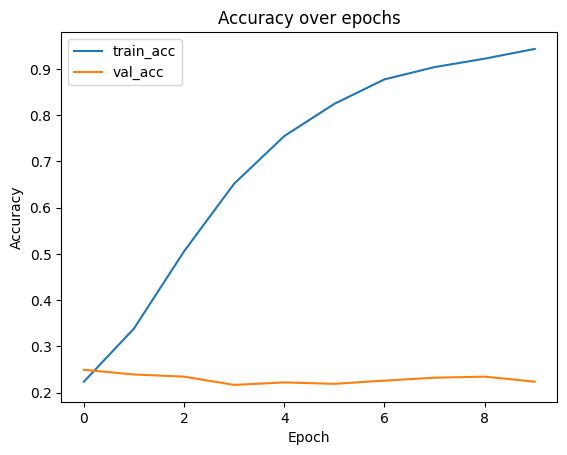

In [ ]:
# 10. Plot
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# 10. Save Model
y_test_pred = np.argmax(model.predict(X_test_pad), axis=1)
submission = pd.DataFrame({'id': df_test['id'], 'label': le.inverse_transform(y_test_pred)})
submission.to_csv('submission_lstm_six_class.csv', index=False)
print('Final LSTM model training & prediction complete.')

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Final LSTM model training & prediction complete.


In [ ]:
model.get_config()

{'name': 'functional_6',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 100),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer_9'},
   'registered_name': None,
   'name': 'input_layer_9',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Embedding',
   'config': {'name': 'embedding_9',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'input_dim': 10000,
    'output_dim': 100,
    'embeddings_initializer': {'module': 'keras.initializers',
     'class_name': 'RandomUniform',
     'config': {'seed': None, 'minval': -0.05, 'maxval': 0.05},
     'registered_name': None},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False},
   'registered_name': None,
   'build_config': {'input_shape': 